# Change of basis

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import statsmodels.api as sm

In [2]:
As = []

corrmat = []

coef = []
std = []
pval = []
fpr = []
tpr = []

TPs = []
FPs = []
TNs = []
FNs = []

TPs_A0 = []
FPs_A0 = []
TNs_A0 = []
FNs_A0 = []

TPs_A1 = []
FPs_A1 = []
TNs_A1 = []
FNs_A1 = []

TPs_B0 = []
FPs_B0 = []
TNs_B0 = []
FNs_B0 = []

TPs_B1 = []
FPs_B1 = []
TNs_B1 = []
FNs_B1 = []

TPs_A0B0 = []
FPs_A0B0 = []
TNs_A0B0 = []
FNs_A0B0 = []

TPs_A1B0 = []
FPs_A1B0 = []
TNs_A1B0 = []
FNs_A1B0 = []

TPs_A0B1 = []
FPs_A0B1 = []
TNs_A0B1 = []
FNs_A0B1 = []

TPs_A1B1 = []
FPs_A1B1 = []
TNs_A1B1 = []
FNs_A1B1 = []

scaler = StandardScaler(with_std=False)
s = 1 # index of last sensitive variable
n = 6 # number of explanatory variables

for i in range(100):
    data = pd.read_csv('synthetic_data_v2010_' + str(i) + '.csv')
    data_norm = scaler.fit_transform(data.iloc[:,:-1])
    data_norm = np.append(data_norm, np.array(data.iloc[:, -1:]), axis=1)
    data_norm = pd.DataFrame(data_norm, columns=list(data.columns))
    E = np.array(data_norm[['A', 'B', 'X1', 'X2', 'X3', 'X4']])
    X_trans = pd.DataFrame()
    A = np.zeros((n,n))
    A[:s+1,:s+1] = np.identity(s+1)
    for j in range(s+1, n):
        fun = lambda a: (E@a.T-E[:, j]).T @ (E@a.T-E[:, j])
        cons = ({'type': 'eq', 'fun': lambda a: E[:, :s+1].T @ E@a.T},
                {'type': 'eq', 'fun': lambda a: np.append(a[s+1:j],a[j+1:])})
        res = minimize(fun, np.array([1,1,1,1,1,1]), constraints=cons)
        A[j,:] = res.x
        X_trans[['A', 'B', 'X1', 'X2', 'X3', 'X4'][j]] = E @ res.x.T
    As.append(A)
    data_corr = X_trans.copy()
    data_corr[['A', 'B', 'Y']] = data[['A', 'B', 'Y']]
    corrmat.append(data_corr.corr())
    x_train, x_test, y_train, y_test = train_test_split(X_trans, data['Y'], test_size=0.2)
    x_train = sm.add_constant(x_train)
    x_test = sm.add_constant(x_test)
    mod = sm.GLM(y_train, x_train, family=sm.genmod.families.family.Binomial())
    res = mod.fit()
    std.append(res.bse)
    coef.append(res.params)
    pval.append(res.pvalues)
    data_pred = data.loc[x_test.index, :]
    data_pred['Y_pred'] = list(map(round, res.predict(x_test)))
    data_pred['Y_pred proba'] = res.predict(x_test)
    fpr.append(metrics.roc_curve(data_pred['Y'], data_pred['Y_pred proba'])[0])
    tpr.append(metrics.roc_curve(data_pred['Y'], data_pred['Y_pred proba'])[1])
    FPs.append(metrics.confusion_matrix(data_pred['Y'], data_pred['Y_pred'])[1, 0])
    FNs.append(metrics.confusion_matrix(data_pred['Y'], data_pred['Y_pred'])[0, 1])
    TPs.append(metrics.confusion_matrix(data_pred['Y'], data_pred['Y_pred'])[0, 0])
    TNs.append(metrics.confusion_matrix(data_pred['Y'], data_pred['Y_pred'])[1, 1])
    # A=0
    FPs_A0.append(metrics.confusion_matrix(data_pred[data_pred['A']<=0]['Y'], data_pred[data_pred['A']<=0]['Y_pred'])[1, 0])
    FNs_A0.append(metrics.confusion_matrix(data_pred[data_pred['A']<=0]['Y'], data_pred[data_pred['A']<=0]['Y_pred'])[0, 1])
    TPs_A0.append(metrics.confusion_matrix(data_pred[data_pred['A']<=0]['Y'], data_pred[data_pred['A']<=0]['Y_pred'])[0, 0])
    TNs_A0.append(metrics.confusion_matrix(data_pred[data_pred['A']<=0]['Y'], data_pred[data_pred['A']<=0]['Y_pred'])[1, 1])
    # A=1
    FPs_A1.append(metrics.confusion_matrix(data_pred[data_pred['A']>0]['Y'], data_pred[data_pred['A']>0]['Y_pred'])[1, 0])
    FNs_A1.append(metrics.confusion_matrix(data_pred[data_pred['A']>0]['Y'], data_pred[data_pred['A']>0]['Y_pred'])[0, 1])
    TPs_A1.append(metrics.confusion_matrix(data_pred[data_pred['A']>0]['Y'], data_pred[data_pred['A']>0]['Y_pred'])[0, 0])
    TNs_A1.append(metrics.confusion_matrix(data_pred[data_pred['A']>0]['Y'], data_pred[data_pred['A']>0]['Y_pred'])[1, 1])
    # B=0
    FPs_B0.append(metrics.confusion_matrix(data_pred[data_pred['B']<=0]['Y'], data_pred[data_pred['B']<=0]['Y_pred'])[1, 0])
    FNs_B0.append(metrics.confusion_matrix(data_pred[data_pred['B']<=0]['Y'], data_pred[data_pred['B']<=0]['Y_pred'])[0, 1])
    TPs_B0.append(metrics.confusion_matrix(data_pred[data_pred['B']<=0]['Y'], data_pred[data_pred['B']<=0]['Y_pred'])[0, 0])
    TNs_B0.append(metrics.confusion_matrix(data_pred[data_pred['B']<=0]['Y'], data_pred[data_pred['B']<=0]['Y_pred'])[1, 1])
    # B=1
    FPs_B1.append(metrics.confusion_matrix(data_pred[data_pred['B']>0]['Y'], data_pred[data_pred['B']>0]['Y_pred'])[1, 0])
    FNs_B1.append(metrics.confusion_matrix(data_pred[data_pred['B']>0]['Y'], data_pred[data_pred['B']>0]['Y_pred'])[0, 1])
    TPs_B1.append(metrics.confusion_matrix(data_pred[data_pred['B']>0]['Y'], data_pred[data_pred['B']>0]['Y_pred'])[0, 0])
    TNs_B1.append(metrics.confusion_matrix(data_pred[data_pred['B']>0]['Y'], data_pred[data_pred['B']>0]['Y_pred'])[1, 1])
    # A=0,B=0
    FPs_A0B0.append(metrics.confusion_matrix(data_pred[(data_pred['A']<=0)&(data_pred['B']<=0)]['Y'], data_pred[(data_pred['A']<=0)&(data_pred['B']<=0)]['Y_pred'])[1, 0])
    FNs_A0B0.append(metrics.confusion_matrix(data_pred[(data_pred['A']<=0)&(data_pred['B']<=0)]['Y'], data_pred[(data_pred['A']<=0)&(data_pred['B']<=0)]['Y_pred'])[0, 1])
    TPs_A0B0.append(metrics.confusion_matrix(data_pred[(data_pred['A']<=0)&(data_pred['B']<=0)]['Y'], data_pred[(data_pred['A']<=0)&(data_pred['B']<=0)]['Y_pred'])[0, 0])
    TNs_A0B0.append(metrics.confusion_matrix(data_pred[(data_pred['A']<=0)&(data_pred['B']<=0)]['Y'], data_pred[(data_pred['A']<=0)&(data_pred['B']<=0)]['Y_pred'])[1, 1])
    # A=1,B=0
    FPs_A1B0.append(metrics.confusion_matrix(data_pred[(data_pred['A']>0)&(data_pred['B']<=0)]['Y'], data_pred[(data_pred['A']>0)&(data_pred['B']<=0)]['Y_pred'])[1, 0])
    FNs_A1B0.append(metrics.confusion_matrix(data_pred[(data_pred['A']>0)&(data_pred['B']<=0)]['Y'], data_pred[(data_pred['A']>0)&(data_pred['B']<=0)]['Y_pred'])[0, 1])
    TPs_A1B0.append(metrics.confusion_matrix(data_pred[(data_pred['A']>0)&(data_pred['B']<=0)]['Y'], data_pred[(data_pred['A']>0)&(data_pred['B']<=0)]['Y_pred'])[0, 0])
    TNs_A1B0.append(metrics.confusion_matrix(data_pred[(data_pred['A']>0)&(data_pred['B']<=0)]['Y'], data_pred[(data_pred['A']>0)&(data_pred['B']<=0)]['Y_pred'])[1, 1])
    # A=0,B=1
    FPs_A0B1.append(metrics.confusion_matrix(data_pred[(data_pred['A']<=0)&(data_pred['B']>0)]['Y'], data_pred[(data_pred['A']<=0)&(data_pred['B']>0)]['Y_pred'])[1, 0])
    FNs_A0B1.append(metrics.confusion_matrix(data_pred[(data_pred['A']<=0)&(data_pred['B']>0)]['Y'], data_pred[(data_pred['A']<=0)&(data_pred['B']>0)]['Y_pred'])[0, 1])
    TPs_A0B1.append(metrics.confusion_matrix(data_pred[(data_pred['A']<=0)&(data_pred['B']>0)]['Y'], data_pred[(data_pred['A']<=0)&(data_pred['B']>0)]['Y_pred'])[0, 0])
    TNs_A0B1.append(metrics.confusion_matrix(data_pred[(data_pred['A']<=0)&(data_pred['B']>0)]['Y'], data_pred[(data_pred['A']<=0)&(data_pred['B']>0)]['Y_pred'])[1, 1])
    # A=1,B=1
    FPs_A1B1.append(metrics.confusion_matrix(data_pred[(data_pred['A']>0)&(data_pred['B']>0)]['Y'], data_pred[(data_pred['A']>0)&(data_pred['B']>0)]['Y_pred'])[1, 0])
    FNs_A1B1.append(metrics.confusion_matrix(data_pred[(data_pred['A']>0)&(data_pred['B']>0)]['Y'], data_pred[(data_pred['A']>0)&(data_pred['B']>0)]['Y_pred'])[0, 1])
    TPs_A1B1.append(metrics.confusion_matrix(data_pred[(data_pred['A']>0)&(data_pred['B']>0)]['Y'], data_pred[(data_pred['A']>0)&(data_pred['B']>0)]['Y_pred'])[0, 0])
    TNs_A1B1.append(metrics.confusion_matrix(data_pred[(data_pred['A']>0)&(data_pred['B']>0)]['Y'], data_pred[(data_pred['A']>0)&(data_pred['B']>0)]['Y_pred'])[1, 1])
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


### Transition matrices

In [3]:
np.mean(As, axis=0), np.std(As, axis=0, ddof=1)

(array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 3.18358448e-01, -7.22629024e-01,  9.99999991e-01,
         -2.00766573e-22,  9.05318645e-23, -2.93009323e-22],
        [-1.46105786e-01, -1.07178320e-01, -3.85219166e-24,
          9.99999996e-01,  4.41335446e-22, -4.91824091e-22],
        [-2.76005923e-01, -1.93272018e+00, -2.82951356e-22,
         -4.74126692e-23,  9.99999992e-01,  1.55434781e-21],
        [ 2.12279040e-01, -4.82293594e-01,  2.32934060e-23,
         -4.23516474e-24,  2.22346149e-22,  9.99999991e-01]]),
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [3.42629274e-03, 5.75677781e-03, 1

In [45]:
np.mean(np.linalg.inv(As), axis=0)

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.71875258e-18,  1.00000000e+00, -4.38757036e-41,
        -1.16759388e-39,  5.20360615e-18,  1.06786445e-38],
       [-3.18358451e-01,  7.22629030e-01,  1.00000001e+00,
         2.00766575e-22,  8.88178428e-18,  2.93009329e-22],
       [ 1.46105787e-01,  1.07178320e-01,  3.85219171e-24,
         1.00000000e+00,  7.63278333e-19,  4.91824098e-22],
       [ 2.76005925e-01,  1.93272020e+00,  2.82951360e-22,
         4.74126699e-23,  1.00000001e+00, -1.55434783e-21],
       [-2.12279042e-01,  4.82293598e-01, -2.32934065e-23,
         4.23516478e-24,  5.55111518e-19,  1.00000001e+00]])

### Correlation matrix

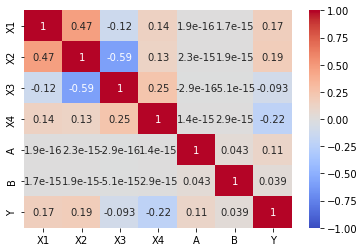

In [4]:
sns.heatmap(np.mean(np.array(corrmat), axis=0), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.xticks([i+0.5 for i in range(7)], list(data.columns))
plt.yticks([i+0.5 for i in range(7)], list(data.columns))
# plt.title('Heatmap of the correlations between variables')
# plt.savefig('heatmap_sim_changebasis_v211.jpg')
plt.show()

### Metrics computation

In [5]:
ACCs = [(TPs[i]+TNs[i])/(TPs[i]+FPs[i]+FNs[i]+TNs[i]) for i in range(100)]

ARs = [(TPs[i]+FPs[i])/(TPs[i]+FPs[i]+FNs[i]+TNs[i]) for i in range(100)]
ARs_A0 = [(TPs_A0[i]+FPs_A0[i])/(TPs_A0[i]+FPs_A0[i]+FNs_A0[i]+TNs_A0[i]) for i in range(100)]
ARs_A1 = [(TPs_A1[i]+FPs_A1[i])/(TPs_A1[i]+FPs_A1[i]+FNs_A1[i]+TNs_A1[i]) for i in range(100)]
ARs_B0 = [(TPs_B0[i]+FPs_B0[i])/(TPs_B0[i]+FPs_B0[i]+FNs_B0[i]+TNs_B0[i]) for i in range(100)]
ARs_B1 = [(TPs_B1[i]+FPs_B1[i])/(TPs_B1[i]+FPs_B1[i]+FNs_B1[i]+TNs_B1[i]) for i in range(100)]
ARs_A0B0 = [(TPs_A0B0[i]+FPs_A0B0[i])/(TPs_A0B0[i]+FPs_A0B0[i]+FNs_A0B0[i]+TNs_A0B0[i]) for i in range(100)]
ARs_A1B0 = [(TPs_A1B0[i]+FPs_A1B0[i])/(TPs_A1B0[i]+FPs_A1B0[i]+FNs_A1B0[i]+TNs_A1B0[i]) for i in range(100)]
ARs_A0B1 = [(TPs_A0B1[i]+FPs_A0B1[i])/(TPs_A0B1[i]+FPs_A0B1[i]+FNs_A0B1[i]+TNs_A0B1[i]) for i in range(100)]
ARs_A1B1 = [(TPs_A1B1[i]+FPs_A1B1[i])/(TPs_A1B1[i]+FPs_A1B1[i]+FNs_A1B1[i]+TNs_A1B1[i]) for i in range(100)]

TPRs = [TPs[i]/(TPs[i]+FNs[i]) for i in range(100)]
TPRs_A0 = [TPs_A0[i]/(TPs_A0[i]+FNs_A0[i]) for i in range(100)]
TPRs_A1 = [TPs_A1[i]/(TPs_A1[i]+FNs_A1[i]) for i in range(100)]
TPRs_B0 = [TPs_B0[i]/(TPs_B0[i]+FNs_B0[i]) for i in range(100)]
TPRs_B1 = [TPs_B1[i]/(TPs_B1[i]+FNs_B1[i]) for i in range(100)]
TPRs_A0B0 = [TPs_A0B0[i]/(TPs_A0B0[i]+FNs_A0B0[i]) for i in range(100)]
TPRs_A1B0 = [TPs_A1B0[i]/(TPs_A1B0[i]+FNs_A1B0[i]) for i in range(100)]
TPRs_A0B1 = [TPs_A0B1[i]/(TPs_A0B1[i]+FNs_A0B1[i]) for i in range(100)]
TPRs_A1B1 = [TPs_A1B1[i]/(TPs_A1B1[i]+FNs_A1B1[i]) for i in range(100)]

FPRs = [FPs[i]/(FPs[i]+TNs[i]) for i in range(100)]
FPRs_A0 = [FPs_A0[i]/(FPs_A0[i]+TNs_A0[i]) for i in range(100)]
FPRs_A1 = [FPs_A1[i]/(FPs_A1[i]+TNs_A1[i]) for i in range(100)]
FPRs_B0 = [FPs_B0[i]/(FPs_B0[i]+TNs_B0[i]) for i in range(100)]
FPRs_B1 = [FPs_B1[i]/(FPs_B1[i]+TNs_B1[i]) for i in range(100)]
FPRs_A0B0 = [FPs_A0B0[i]/(FPs_A0B0[i]+TNs_A0B0[i]) for i in range(100)]
FPRs_A1B0 = [FPs_A1B0[i]/(FPs_A1B0[i]+TNs_A1B0[i]) for i in range(100)]
FPRs_A0B1 = [FPs_A0B1[i]/(FPs_A0B1[i]+TNs_A0B1[i]) for i in range(100)]
FPRs_A1B1 = [FPs_A1B1[i]/(FPs_A1B1[i]+TNs_A1B1[i]) for i in range(100)]

### Regression weights

In [6]:
np.mean(coef, axis=0), 1.96*np.std(coef, ddof=1, axis=0)/10

(array([-1.65317001,  0.54710936,  2.71763876,  0.24015169, -2.46142912]),
 array([0.0023286 , 0.00400386, 0.01019612, 0.001539  , 0.00697024]))

In [7]:
np.mean(std, axis=0), 1.96*np.std(std, axis=0, ddof=1)/10

(array([0.01084068, 0.02073199, 0.05211317, 0.00708406, 0.03216911]),
 array([1.13404473e-05, 1.73847632e-05, 4.51074826e-05, 5.43835632e-06,
        3.40386438e-05]))

In [8]:
np.mean(pval, axis=0), 1.96*np.std(pval, ddof=1, axis=0)/10

(array([0.00000000e+000, 1.44662555e-126, 0.00000000e+000, 1.81450664e-220,
        0.00000000e+000]),
 array([0.00000000e+000, 2.83538592e-126, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000]))

### Global confusion matrix

In [9]:
np.mean(TPs), np.mean(FNs), np.mean(FPs), np.mean(TNs)

(15582.14, 421.37, 3421.59, 574.9)

In [10]:
1.96*np.std(TPs, ddof=1)/10, 1.96*np.std(FNs, ddof=1)/10, 1.96*np.std(FPs, ddof=1)/10, 1.96*np.std(TNs, ddof=1)/10

(11.788969019889702, 5.425682396182292, 11.524558078268942, 5.231304760282037)

In [43]:
data_pred['Y_pred'].value_counts()

0    19003
1      997
Name: Y_pred, dtype: int64

### Accuracy

In [11]:
np.mean(ACCs), 1.96*np.std(ACCs, ddof=1)/10*100

(0.8078519999999999, 0.05581455383280924)

### ROC

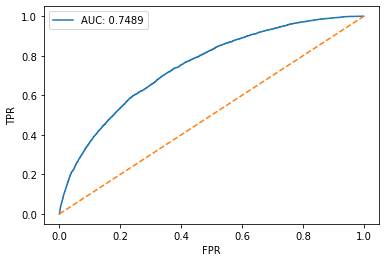

In [12]:
plt.plot(fpr[-1], tpr[-1], label='AUC: ' + str(np.round(metrics.roc_auc_score(data_pred['Y'], data_pred['Y_pred proba']), 4)))
plt.plot([0, 1], [0, 1], linestyle='dashed')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
# plt.savefig('ROC_sim_changebasis_v311.png')

### AR

In [13]:
np.mean(ARs), np.mean(ARs_A0), np.mean(ARs_A1), np.mean(ARs_B0), np.mean(ARs_B1)

(0.9501864999999999,
 0.9492534489355978,
 0.952368920097619,
 0.9494336177286309,
 0.9502714331193406)

In [16]:
1.96*np.std(ARs, ddof=1)/10*100, 1.96*np.std(ARs_A0, ddof=1)/10*100, 1.96*np.std(ARs_A1, ddof=1)/10*100, 1.96*np.std(ARs_B0, ddof=1)/10*100, 1.96*np.std(ARs_B1, ddof=1)/10*100

(0.04415899261907265,
 0.05037659352251111,
 0.06010697441474175,
 0.10727011524821377,
 0.04457762699004595)

In [14]:
np.mean(np.array(ARs_A0)-np.array(ARs_A1)), 1.96*np.std(np.array(ARs_A0)-np.array(ARs_A1), ddof=1)/10*100

(-0.003115471162021177, 0.06559440660252813)

In [15]:
np.mean(np.array(ARs_B0)-np.array(ARs_B1)), 1.96*np.std(np.array(ARs_B0)-np.array(ARs_B1), ddof=1)/10*100

(-0.0008378153907096841, 0.10498249126834963)

In [41]:
# np.mean(ARs_A0B0), 1.96*np.std(ARs_A0B0, ddof=1)/10*100
np.mean(ARs_A1B0), 1.96*np.std(ARs_A1B0, ddof=1)/10*100
# np.mean(ARs_A0B1), 1.96*np.std(ARs_A0B1, ddof=1)/10*100
# np.mean(ARs_A1B1), 1.96*np.std(ARs_A1B1, ddof=1)/10*100

(0.9518198763574255, 0.22726360532463208)

### TPR

In [18]:
np.mean(TPRs), np.mean(TPRs_A0), np.mean(TPRs_A1), np.mean(TPRs_B0), np.mean(TPRs_B1)

(0.9736706481488017,
 0.9714602280252512,
 0.9795249505361278,
 0.9694125648461793,
 0.9741772033042347)

In [19]:
1.96*np.std(TPRs, ddof=1)/10*100, 1.96*np.std(TPRs_A0, ddof=1)/10*100, 1.96*np.std(TPRs_A1, ddof=1)/10*100, 1.96*np.std(TPRs_B0, ddof=1)/10*100, 1.96*np.std(TPRs_B1, ddof=1)/10*100

(0.033719093183102976,
 0.03989119777818869,
 0.04710828870104468,
 0.09070406835659704,
 0.033195751169123634)

In [20]:
np.mean(np.array(TPRs_A0)-np.array(TPRs_A1)), 1.96*np.std(np.array(TPRs_A0)-np.array(TPRs_A1), ddof=1)/10*100

(-0.008064722510876457, 0.05572644034231049)

In [21]:
np.mean(np.array(TPRs_B0)-np.array(TPRs_B1)), 1.96*np.std(np.array(TPRs_B0)-np.array(TPRs_B1), ddof=1)/10*100

(-0.00476463845805543, 0.0873511563888438)

In [36]:
# np.mean(TPRs_A0B0), 1.96*np.std(TPRs_A0B0, ddof=1)/10*100
# np.mean(TPRs_A1B0), 1.96*np.std(TPRs_A1B0, ddof=1)/10*100
# np.mean(TPRs_A0B1), 1.96*np.std(TPRs_A0B1, ddof=1)/10*100
np.mean(TPRs_A1B1), 1.96*np.std(TPRs_A1B1, ddof=1)/10*100

(0.979862119030126, 0.044353969850113285)

### FPR

In [23]:
np.mean(FPRs), np.mean(FPRs_A0), np.mean(FPRs_A1), np.mean(FPRs_B0), np.mean(FPRs_B1), np.mean(FPRs_A0B0), np.mean(FPRs_A1B0), np.mean(FPRs_A0B1), np.mean(FPRs_A1B1)

(0.8561362329229872,
 0.8413501287896784,
 0.8781617730514998,
 0.8385284466324459,
 0.8576124083866742,
 0.8261698570247427,
 0.8633621274736827,
 0.8427958030371105,
 0.8791958128578331)

In [24]:
1.96*np.std(FPRs, ddof=1)/10*100, 1.96*np.std(FPRs_A0, ddof=1)/10*100, 1.96*np.std(FPRs_A1, ddof=1)/10*100, 1.96*np.std(FPRs_B0, ddof=1)/10*100, 1.96*np.std(FPRs_B1, ddof=1)/10*100

(0.12992690274570434,
 0.1697635070021525,
 0.16820910011473206,
 0.4003408759368025,
 0.13397421719200758)

In [25]:
np.mean(np.array(FPRs_A0)-np.array(FPRs_A1)), 1.96*np.std(np.array(FPRs_A0)-np.array(FPRs_A1), ddof=1)/10*100

(-0.03681164426182137, 0.2226948724588452)

In [26]:
np.mean(np.array(FPRs_B0)-np.array(FPRs_B1)), 1.96*np.std(np.array(FPRs_B0)-np.array(FPRs_B1), ddof=1)/10*100

(-0.01908396175422853, 0.40985615476051607)

In [40]:
# np.mean(FPRs_A0B0), 1.96*np.std(FPRs_A0B0, ddof=1)/10*100
# np.mean(FPRs_A1B0), 1.96*np.std(FPRs_A1B0, ddof=1)/10*100
# np.mean(FPRs_A0B1), 1.96*np.std(FPRs_A0B1, ddof=1)/10*100
np.mean(FPRs_A1B1), 1.96*np.std(FPRs_A1B1, ddof=1)/10*100

(0.8791958128578331, 0.1671390211474873)